## Loading the important Libraries

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re
from collections import defaultdict
from data.scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
from nltk import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Loading the contents

In [2]:
f_bodies = open('data/train_bodies.csv', 'r', encoding='utf-8')
csv_bodies = csv.DictReader(f_bodies)
bodies = []
for row in csv_bodies:
    body_id = int(row['Body ID'])
    if (body_id + 1) > len(bodies):
        bodies += [None] * (body_id + 1 - len(bodies))
    bodies[body_id] = row['articleBody']
f_bodies.close()
body_inverse_index = {bodies[i]: i for i in range(len(bodies))}

all_unrelated, all_discuss, all_agree, all_disagree = [], [], [], []  # each article = (headline, body, stance)

f_stances = open('data/train_stances.csv', 'r', encoding='utf-8')
csv_stances = csv.DictReader(f_stances)
for row in csv_stances:
    body = bodies[int(row['Body ID'])]
    if row['Stance'] == 'unrelated':
        all_unrelated.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'discuss':
        all_discuss.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'agree':
        all_agree.append((row['Headline'], body, row['Stance']))
    elif row['Stance'] == 'disagree':
        all_disagree.append((row['Headline'], body, row['Stance']))
f_stances.close()

In [3]:
print('\tUnrltd\tDiscuss\t Agree\tDisagree')
print('All\t', len(all_unrelated), '\t', len(all_discuss), '\t', len(all_agree), '\t', len(all_disagree))

train_unrelated = all_unrelated[:len(all_unrelated) * 9 // 100]
train_discuss = all_discuss[:len(all_discuss) * 9 // 100]
train_agree = all_agree[:len(all_agree) * 9 // 100]
train_disagree = all_disagree[:len(all_disagree) * 9 // 100]


val_unrelated = all_unrelated[len(all_unrelated) * 9 // 100:]
val_discuss = all_discuss[len(all_discuss) * 9 // 100:]
val_agree = all_agree[len(all_agree) * 9 // 100:]
val_disagree = all_disagree[len(all_disagree) * 9 // 100:]

# train_unrelated = all_unrelated[:len(all_unrelated) //100]
# train_discuss = all_discuss[:len(all_discuss) //100]
# train_agree = all_agree[:len(all_agree) //100]
# train_disagree = all_disagree[:len(all_disagree) //100]


val_unrelated = all_unrelated[len(all_unrelated) * 7 // 10:]
val_discuss = all_discuss[len(all_discuss) * 7 // 10:]
val_agree = all_agree[len(all_agree) * 7 // 10:]
val_disagree = all_disagree[len(all_disagree) * 7 // 10:]

val_unrelated = val_unrelated[len(val_unrelated) * 9 // 10:]
val_discuss = val_discuss[len(val_discuss) * 9 // 10:]
val_agree = val_agree[len(val_agree) * 9 // 10:]
val_disagree = val_disagree[len(val_disagree) * 9 // 10:]



print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))

	Unrltd	Discuss	 Agree	Disagree
All	 36545 	 8909 	 3678 	 840
Train	 3289 	 801 	 331 	 75
Valid.	 1097 	 268 	 111 	 26


# Uniform distribution of Data

In [4]:
print('Train\t', len(train_unrelated), '\t', len(train_discuss), '\t', len(train_agree), '\t', len(train_disagree))
print('Valid.\t', len(val_unrelated), '\t', len(val_discuss), '\t', len(val_agree), '\t', len(val_disagree))
train_all = (train_unrelated + train_discuss + train_agree + train_disagree)

# each article = (headline, body, stance)
random.Random(0).shuffle(train_all)
train_all = np.array(train_all)

val_all = val_unrelated + val_discuss + val_agree + val_disagree
random.Random(0).shuffle(val_all)
val_all = np.array(val_all)

print('Train (Total)', train_all.shape, '\tValidation (Total)', val_all.shape)

print()
print(np.count_nonzero(train_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(train_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(train_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(train_all[:, 2] == 'disagree'))
print(np.count_nonzero(val_all[:, 2] == 'unrelated'), '\t',
      np.count_nonzero(val_all[:, 2] == 'discuss'), '\t',
      np.count_nonzero(val_all[:, 2] == 'agree'), '\t',
      np.count_nonzero(val_all[:, 2] == 'disagree'))

Train	 3289 	 801 	 331 	 75
Valid.	 1097 	 268 	 111 	 26
Train (Total) (4496, 3) 	Validation (Total) (1502, 3)

3289 	 801 	 331 	 75
1097 	 268 	 111 	 26


In [5]:
# Tokenise text
pattern = re.compile("[^a-zA-Z0-9 ]+")  # strip punctuation, symbols, etc.
stop_words = set(stopwords.words('english'))
def tokenise(text):
    text = pattern.sub('', text.replace('\n', ' ').replace('-', ' ').lower())
    text = [word for word in word_tokenize(text) if word not in stop_words]
    return text

# for i in range(9):
#     print(train_all[i, 0]);print('Tokenized form is ------>',tokenise(train_all[i, 0]))
#     print()

In [6]:
# Compute term-frequency of words in documents
def doc_to_tf(text, ngram=1):
    words = tokenise(text)
    ret = defaultdict(float)
    for i in range(len(words)):
        for j in range(1, ngram+1):
            if i - j < 0:
                break
            word = [words[i-k] for k in range(j)]
            ret[word[0] if ngram == 1 else tuple(word)] += 1.0
    return ret
    
# for i in range(5):
#     print(train_all[i, 0]);print('Term frequency form is ------->',doc_to_tf(train_all[i, 0]))
#     print()


In [7]:
# print(train_all[0, 0]);print('Term frequency form is ------->',doc_to_tf(train_all[0, 0], ngram=2))

In [8]:
# Build corpus of article bodies and headlines in training dataset
corpus = np.r_[train_all[:, 1], train_all[:, 0]]  # 0 to 4496 are bodies, 4496 to 8992 are headlines

corpus.shape
# print(corpus[0])
# print(corpus[4497])

(8992,)

In [9]:
# Learn idf of every word in the corpus
df = defaultdict(float)
for doc in tqdm(corpus):
    words = tokenise(doc)
    seen = set()
    for word in words:
        if word not in seen:
            df[word] += 1.0
            seen.add(word)

print(list(df.items())[:10])

100%|██████████| 8992/8992 [00:08<00:00, 1048.87it/s]

[('trip', 248.0), ('bali', 115.0), ('turned', 347.0), ('dylan', 98.0), ('thomas', 187.0), ('real', 566.0), ('life', 763.0), ('spiderman', 39.0), ('21', 135.0), ('year', 1624.0)]


In [10]:
num_docs = corpus.shape[0]
idf = defaultdict(float)
for word, val in tqdm(df.items()):
    idf[word] = np.log((1.0 + num_docs) / (1.0 + val)) + 1.0  # smoothed idf

print(list(idf.items())[:10])

100%|██████████| 21414/21414 [00:00<00:00, 523792.68it/s]

[('trip', 4.586748879449808), ('bali', 5.350611584808151), ('turned', 4.251999296140041), ('dylan', 5.509081925779926), ('thomas', 4.867759813084566), ('real', 3.7638424721867634), ('life', 3.465633986747995), ('spiderman', 6.415322321800579), ('21', 5.191546890178463), ('year', 2.7109386811506777)]


In [11]:
# Load GLoVe word vectors
f_glove = open("data/glove.6B.50d.txt", "rb")  # download from https://nlp.stanford.edu/projects/glove/
glove_vectors = {}
for line in tqdm(f_glove):
    glove_vectors[str(line.split()[0]).split("'")[1]] = np.array(list(map(float, line.split()[1:])))

print(glove_vectors['glove'])

400000it [00:07, 56716.16it/s]

[-1.2879   -0.14538  -0.016613  1.1387    1.1317    0.20705  -0.47351
  0.15898   0.67879   0.2382    0.11621   0.26053  -0.8379    1.1232
  0.31469  -0.47904  -0.33717  -0.34492  -0.72053  -1.0543   -0.58476
 -0.42184  -0.56977  -1.1697   -0.50389  -1.4706   -0.22005   1.1314
  1.0829   -1.5477    0.77931  -0.22865   0.33369   0.52067   0.22109
  1.1267    0.11704   1.1647    0.5875   -0.079243  0.022386  0.90118
 -0.37459   0.82637  -0.41061  -0.95039   0.44121  -0.58558   0.12594
 -0.71778 ]


In [12]:
# Convert a document to GloVe vectors, by computing tf-idf of each word * GLoVe of word / total tf-idf for document
def doc_to_glove(doc):
    doc_tf = doc_to_tf(doc)
    doc_tf_idf = defaultdict(float)
    for word, tf in doc_tf.items():
        doc_tf_idf[word] = tf * idf[word]
        
    doc_vector = np.zeros(glove_vectors['glove'].shape[0])
    if np.sum(list(doc_tf_idf.values())) == 0.0:  # edge case: document is empty
        return doc_vector
    
    for word, tf_idf in doc_tf_idf.items():
        if word in glove_vectors:
            doc_vector += glove_vectors[word] * tf_idf
    doc_vector /= np.sum(list(doc_tf_idf.values()))
    return doc_vector

for i in range(2):
    print(train_all[i, 0], doc_to_glove(train_all[i, 0]))

Boko Haram claims to have German hostage, denies ceasefire [ 0.66238995 -0.20231485  0.02238153 -0.19057948  0.33594892  0.36391509
 -0.07722483  0.32337541 -0.29860956 -0.1425318   0.26924971 -0.45753202
 -0.45144652 -0.17819528  0.39194451  0.05272324  0.24158074 -0.04484998
  0.09402494  0.55394359  0.11073741  0.54832118 -0.1604362   0.32599829
 -0.34731733 -1.41175663  0.01822305 -0.24954153 -0.06021231  0.39575822
  1.70649153 -0.55443727 -0.91826336  0.2360565  -0.2037994  -0.37732488
 -0.03705008 -0.90433473 -0.48686358  0.05834009  0.26639018 -0.22978682
  0.39911576 -0.42832519  0.44631194 -0.53336104 -0.56374759  0.76702037
 -0.12329446 -0.49944507]
ISIS Militant “Jihadi John” Identified As Young West Londoner [ 0.04856468  0.12725143  0.18448444 -0.47197083  0.62240648  0.09067463
 -0.66387388 -0.09484841 -0.05410015 -0.06212942 -0.10961955 -0.10941869
 -0.30243727  0.16762591 -0.23097195 -0.10332358  0.38766934 -0.10083799
 -0.18275591  0.54325033 -0.3961248   0.44608015  

In [13]:
# Compute cosine similarity of GLoVe vectors for all headline-body pairs
def dot_product(vec1, vec2):
    sigma = 0.0
    for i in range(vec1.shape[0]):  # assume vec1 and vec2 has same shape
        sigma += vec1[i] * vec2[i]
    return sigma
    
def magnitude(vec):
    return np.sqrt(np.sum(np.square(vec)))
        
def cosine_similarity(doc):
    headline_vector = doc_to_glove(doc[0])
    body_vector = doc_to_glove(doc[1])
    
    if magnitude(headline_vector) == 0.0 or magnitude(body_vector) == 0.0:  # edge case: document is empty
        return 0.0
    
    return dot_product(headline_vector, body_vector) / (magnitude(headline_vector) * magnitude(body_vector))

for i in range(10):
    # unrelated should have lower than rest
    print(cosine_similarity(train_all[i]), train_all[i, 2])
print(cosine_similarity(train_all[27069//100]), tokenise(train_all[27069//100, 0]), tokenise(train_all[2706//100, 1]))  # edge case

0.516338632721861 unrelated
0.6147001036215263 unrelated
0.6206811818772908 unrelated
0.6741951941010255 unrelated
0.6797658918977083 unrelated
0.7887769480600915 unrelated
0.6526468931922231 unrelated
0.7330202149965123 unrelated
0.7144093706686057 unrelated
0.6221969807577564 unrelated
0.7302817243230582 ['hoax', 'banksy', 'arrested', 'london', 'story', 'dupes', 'internet'] ['thousands', 'social', 'media', 'users', 'distributing', 'unverified', 'photo', 'claims', 'show', 'body', 'isis', 'leader', 'abu', 'bakr', 'al', 'baghdadi', 'purportedly', 'killed', 'us', 'airstrikes', 'three', 'senior', 'members', 'isis', 'including', 'aide', 'al', 'baghdadi', 'also', 'killed', 'us', 'air', 'strikes', 'talking', 'nbc', 'news', 'senior', 'iraqi', 'official', 'confirmed', 'deaths', 'thursday', 'strike', 'isis', 'stronghold', 'mosul', 'killed', 'abu', 'hajar', 'al', 'sufi', 'aide', 'al', 'baghdadi', 'well', 'explosives', 'operative', 'military', 'leader', 'nearby', 'tal', 'afar', 'source', 'said', 

In [14]:
# Compute the KL-Divergence of language model (LM) representations of the headline and the body
def divergence(lm1, lm2):
    sigma = 0.0
    for i in range(lm1.shape[0]):  # assume lm1 and lm2 has same shape
        sigma += lm1[i] * np.log(lm1[i] / lm2[i])
    return sigma

def kl_divergence(doc, eps=0.1):
    # Convert headline and body to 1-gram representations
    tf_headline = doc_to_tf(doc[0])
    tf_body = doc_to_tf(doc[1])
    
    # Convert dictionary tf representations to vectors (make sure columns match to the same word)
    words = set(tf_headline.keys()).union(set(tf_body.keys()))
    vec_headline, vec_body = np.zeros(len(words)), np.zeros(len(words))
    i = 0
    for word in words:
        vec_headline[i] += tf_headline[word]
        vec_body[i] = tf_body[word]
        i += 1
    
    # Compute a simple 1-gram language model of headline and body
    lm_headline = vec_headline + eps
    lm_headline /= np.sum(lm_headline)
    lm_body = vec_body + eps
    lm_body /= np.sum(lm_body)
    
    # Return KL-divergence of both language models
    return divergence(lm_headline, lm_body)

# for i in range(10):
#     # unrelated should have higher than rest
#     print(kl_divergence(train_all[i]), train_all[i, 2])
# print(kl_divergence(train_all[27069//100]), tokenise(train_all[27069//100, 0]), tokenise(train_all[27069//100, 1]))  # edge case

In [15]:
# Other feature 1
def ngram_overlap(doc):
    # Returns how many times n-grams (up to 3-gram) that occur in the article's headline occur on the article's body.
    tf_headline = doc_to_tf(doc[0], ngram=3)
    tf_body = doc_to_tf(doc[1], ngram=3)
    matches = 0.0
    for words in tf_headline.keys():
        if words in tf_body:
            matches += tf_body[words]
    return np.power((matches / len(tokenise(doc[1]))), 1 / np.e)  # normalise for document length

for i in range(10):
    # unrelated should have lower than rest
    print(ngram_overlap(train_all[i]), train_all[i, 2])

0.0 unrelated
0.0 unrelated
0.1729008805195721 unrelated
0.0 unrelated
0.1109609842438206 unrelated
0.0 unrelated
0.0 unrelated
0.1820941643725163 unrelated
0.0 unrelated
0.0 unrelated


In [16]:
# Define function to convert (headline, body) to feature vectors for each document
ftrs = [cosine_similarity, kl_divergence, ngram_overlap]
def to_feature_array(doc):
    vec = np.array([0.0] * len(ftrs))
    for i in range(len(ftrs)):
        vec[i] = ftrs[i](doc)
    return vec



In [17]:
# Initialise X (matrix of feature vectors) for train dataset
x_train = np.array([to_feature_array(doc) for doc in tqdm(train_all)])
print(x_train[:10])
# Initialise X (matrix of feature vectors) for train dataset
x_test = np.array([to_feature_array(doc) for doc in tqdm(val_all)])
print(x_test[:10])

  1%|          | 12/1502 [00:00<00:15, 97.98it/s]

[[0.51633863 1.58727138 0.        ]
 [0.6147001  1.92115372 0.        ]
 [0.62068118 1.44675639 0.17290088]
 [0.67419519 1.57956287 0.        ]
 [0.67976589 1.18411357 0.11096098]
 [0.78877695 1.48866337 0.        ]
 [0.65264689 1.11588282 0.        ]
 [0.73302021 1.4365906  0.18209416]
 [0.71440937 1.51485019 0.        ]
 [0.62219698 1.60923352 0.        ]]


100%|██████████| 1502/1502 [00:13<00:00, 109.91it/s]

[[0.61968955 2.24638509 0.        ]
 [0.55638816 1.36953941 0.        ]
 [0.79253648 0.55102385 0.29848116]
 [0.53879465 1.16077427 0.        ]
 [0.72074527 1.55334888 0.        ]
 [0.45542955 1.48772752 0.        ]
 [0.51559549 1.26445998 0.        ]
 [0.61649085 2.2015359  0.        ]
 [0.46606249 1.3391045  0.        ]
 [0.82703033 0.80797574 0.19607152]]


In [18]:
# Define label <-> int mappings for y
label_to_int = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
int_to_label = ['agree', 'disagree', 'discuss', 'unrelated']

# Initialise Y (gold output vector) for train dataset
y_train = np.array([label_to_int[i] for i in train_all[:, 2]])
y_test = np.array([label_to_int[i] for i in val_all[:, 2]])


[('g', 'agree'), ('r', 'disagree'), ('b', 'discuss'), ('y', 'unrelated')]


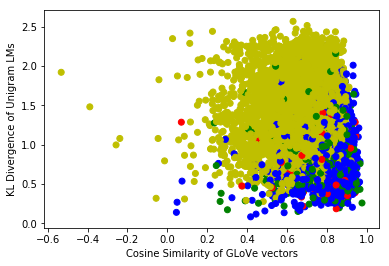

In [19]:
# Plot GLoVe distance vs KL-Divergence on a coloured scatter plot with different colours for each label
colours = np.array(['g', 'r', 'b', 'y'])
plt.scatter(list(x_train[:, 0]), list(x_train[:, 1]), c=colours[y_train])
plt.xlabel('Cosine Similarity of GLoVe vectors')
plt.ylabel('KL Divergence of Unigram LMs')
print([(colours[i], int_to_label[i]) for i in range(len(int_to_label))])
plt.show()

In [20]:
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
print(y_test[:10])

(4496,)
(1502,)
[3 3 3 3 3 3 3 3 3 3]
[3 3 2 3 3 3 3 3 3 3]


In [21]:
# Check integrity of X and Y
print(np.where(np.isnan(x_train)))
print(np.where(np.isfinite(x_train) == False))
x_train = x_train[:4096]
y_train = y_train[:4096]
print(x_train.shape)
print(y_train.shape)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(4096, 3)
(4096,)


In [24]:
import pandas as pd
data_train = pd.DataFrame(x_train,columns=['tfidf','kl_divergence','n_gram'])
data_train['y_out'] = y_train

data_train.head(10)
data_train.shape

(4096, 4)

In [30]:

data_test = pd.DataFrame(x_test,columns=['tfidf','kl_divergence','n_gram'])
data_test['y_out'] = y_test
data_test.shape

(1502, 4)

In [35]:
data = pd.concat([data_train, data_test], axis=0)
data.to_csv('features.csv',index=False)

In [36]:
df = pd.read_csv('features.csv')
df.head(10)

,tfidf,kl_divergence,n_gram,y_out
0,0.516339,1.587271,0.000000,3
1,0.614700,1.921154,0.000000,3
2,0.620681,1.446756,0.172901,3
3,0.674195,1.579563,0.000000,3
4,0.679766,1.184114,0.110961,3
5,0.788777,1.488663,0.000000,3
6,0.652647,1.115883,0.000000,3
7,0.733020,1.436591,0.182094,3
8,0.714409,1.514850,0.000000,3
9,0.622197,1.609234,0.000000,3
